# Определение стоимости автомобилей

**Описание проекта:**   
Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей.

**Цель исследования:**   
Нужно построить модель для определения стоимости. Заказчику важны: качество предсказания, скорость предсказания, время обучения.

**Описание данных:**   
Датасет с данными по машинам. Более 350 тысяч строк


**Ход исследования:**  
- [1. Подготовка данных](#подготовка)
- [2. Обучение моделей](#обучение)
- [3. Анализ моделей](#анализ)
- [4. Вывод](#вывод)

**Общий вывод:**   
По результатам обучения 2 моделей заказчику можем сообщить, что LightGBM предсказывает лучше (RMSE 1568), чем DecisionTreeRegressor (RMSE 1836), но дольше.

<a id="подготовка"></a> 
## Подготовка данных

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time

from phik.report import plot_correlation_matrix
from phik import report

from ydata_profiling import ProfileReport
import sweetviz as sv

import lightgbm as lgb
from sklearn.tree import DecisionTreeRegressor

from sklearn.model_selection import train_test_split, RandomizedSearchCV

from sklearn.preprocessing import  OrdinalEncoder

from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.metrics import mean_squared_error

RANDOM_STATE = 42

pd.set_option('display.max_colwidth', 200)

C:\Users\Roman\.conda\envs\ds_clean\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
try:
    df = pd.read_csv('/datasets/autos.csv')
except:
    df = pd.read_csv('https://code.s3.yandex.net/datasets/autos.csv')
df.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


Приведем названия столбцов к нижнему регистру

In [3]:
df.columns = df.columns.str.lower()

In [4]:
def opening(df):
    print('ПЕРВЫЕ ПЯТЬ СТРОК')
    display(df.head())
    
    print('ИНФОРМАЦИЯ О ДАННЫХ')
    df.info()
    print('\n')
    
    print('КОЛИЧЕСТВО ПРОПУЩЕННЫХ ЗНАЧЕНИЙ')
    print(df.isna().sum(), '\n')
    
    print('КОЛИЧЕСТВО ПРОПУЩЕННЫХ ЗНАЧЕНИЙ, %')
    print(df.isna().mean() * 100, '\n')
    print(df.isna().sum() / df.shape[0] * 100)
    
    print('ОПИСАНИЕ ЧИСЛОВЫХ ДАННЫХ')
    print(df.describe(), '\n')
    
    print('УНИКАЛЬНЫЕ ЗНАЧЕНИЯ КАТЕГОРИАЛЬНЫХ ПЕРЕМЕННЫХ')
    cat_cols = df.select_dtypes(include = ['object', 'category'])
    for i in cat_cols:
        print(f"{i}: {df[i].nunique()} уникальные значения -  {df[i].unique()}")
    print('\n')
    
    print('КОЛИЧЕСТВО ДУБЛИКАТОВ')
    print(df.duplicated().sum())
        
    print('РАСПРЕДЕЛЕНИЕ ДАННЫХ КОЛИЧЕСТВЕННЫХ СТОЛБЦОВ')
    df.hist(figsize = (15,10))

ПЕРВЫЕ ПЯТЬ СТРОК


,datecrawled,price,vehicletype,registrationyear,gearbox,power,model,kilometer,registrationmonth,fueltype,brand,repaired,datecreated,numberofpictures,postalcode,lastseen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


ИНФОРМАЦИЯ О ДАННЫХ
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   datecrawled        354369 non-null  object
 1   price              354369 non-null  int64 
 2   vehicletype        316879 non-null  object
 3   registrationyear   354369 non-null  int64 
 4   gearbox            334536 non-null  object
 5   power              354369 non-null  int64 
 6   model              334664 non-null  object
 7   kilometer          354369 non-null  int64 
 8   registrationmonth  354369 non-null  int64 
 9   fueltype           321474 non-null  object
 10  brand              354369 non-null  object
 11  repaired           283215 non-null  object
 12  datecreated        354369 non-null  object
 13  numberofpictures   354369 non-null  int64 
 14  postalcode         354369 non-null  int64 
 15  lastseen           354369 non-null  object
dtype

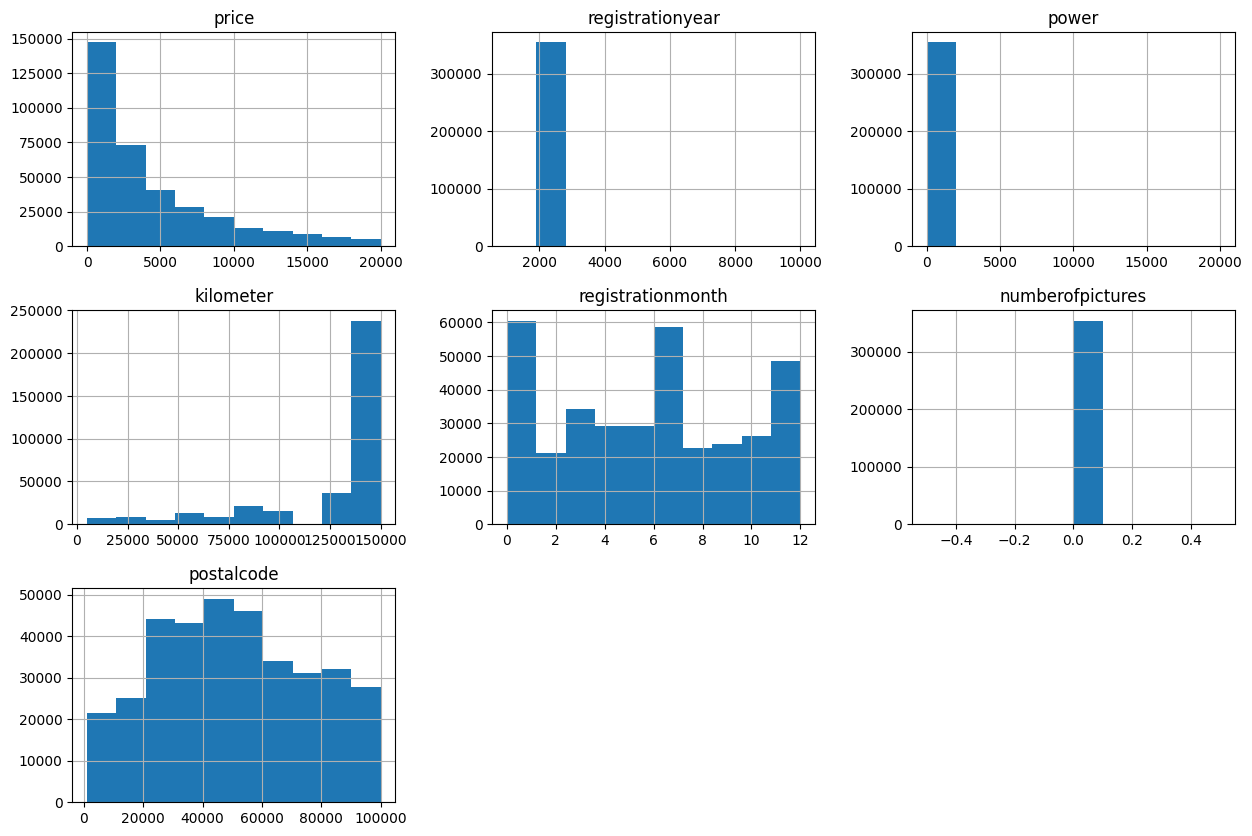

In [5]:
opening(df)

In [6]:
print(f" количество аномальных значений 'registrationyear' - "
    f"{df[(df['registrationyear'] <1970) | (df['registrationyear'] >2020)].shape[0] / df.shape[0] * 100} %")

print(f" количество аномальных значений 'power' - {df[(df['power'] > 500)].shape[0] / df.shape[0] * 100} %")

print(f" количество 'price', равных нулю - {df[(df['price'] == 0)].shape[0] / df.shape[0] * 100} %")

print(f" количество 'model' NaN - {df['model'].isna().sum() / df.shape[0] * 100} %")

print(f" количество 'power', равных нулю - {df[(df['power'] == 0)].shape[0] / df.shape[0] * 100} %")

 количество аномальных значений 'registrationyear' - 0.40720266163236624 %
 количество аномальных значений 'power' - 0.12952600255665705 %
 количество 'price', равных нулю - 3.0397692800442475 %
 количество 'model' NaN - 5.560587974681758 %
 количество 'power', равных нулю - 11.351162206626427 %


**Создадим для удобства другой датасет с теми же данными df и начнем работу с удалением/преобразованием:**
1) Удалим дубликаты
2) Удалим явные аномалии, где в столбце "registrationyear" плохие данные. Это всего 0.4%  
3) Удалим явные аномалии, где в столбце "power" плохие данные. Это всего 0.13%  
4) В столбце price есть значения 0. Скорее всего это ошибка в данных. Это исказит предсказания нашей модели. Тоже удалим эти данные, это всего 3.04 % в общих  
5) Удалим все строки, где неизвестна модель машины. Это важнейший для нас параметр для предсказания, без него нет смысла строить модели обучения - 5,56%  
6) В графе fueltype есть petrol и gasoline. Это два названия "бензин" в разных странах. Заменим на petrol
7) Исключим 3 столбца временные - datecrawled, datecreated, lastseen. Исключим столбец numberofpictures - там везде ноль фотографий. И исключим postalcode - он не несет никакой смысловой нагрузки

In [7]:
df1 = df.drop_duplicates()
df1 = df1[(df1['registrationyear'] >= 1970) & (df1['registrationyear'] <=2016)]
df1 = df1[(df1['power'] <= 500)]
df1 = df1[df1['price'] != 0]
df1 = df1.dropna(subset = ['model'])
df1['fueltype'] = df1['fueltype'].replace('gasoline', 'petrol')
df1 = df1.drop(columns = ['datecrawled', 'datecreated', 'lastseen', 'numberofpictures', 'postalcode'])
df1 = df1.reset_index(drop=True)


print(f"В общей сложности было удалено {round(100 - df1.shape[0] / df.shape[0] *100, 2)}% данных от первоначального датасета")

В общей сложности было удалено 11.67% данных от первоначального датасета


In [8]:
df1.head(3)

,price,vehicletype,registrationyear,gearbox,power,model,kilometer,registrationmonth,fueltype,brand,repaired
0,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN
1,9800,suv,2004,auto,163,grand,125000,8,petrol,jeep,NaN
2,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no


In [9]:
df1.isna().sum()

price                    0
vehicletype          16147
registrationyear         0
gearbox              12733
power                    0
model                    0
kilometer                0
registrationmonth        0
fueltype             19050
brand                    0
repaired             52845
dtype: int64

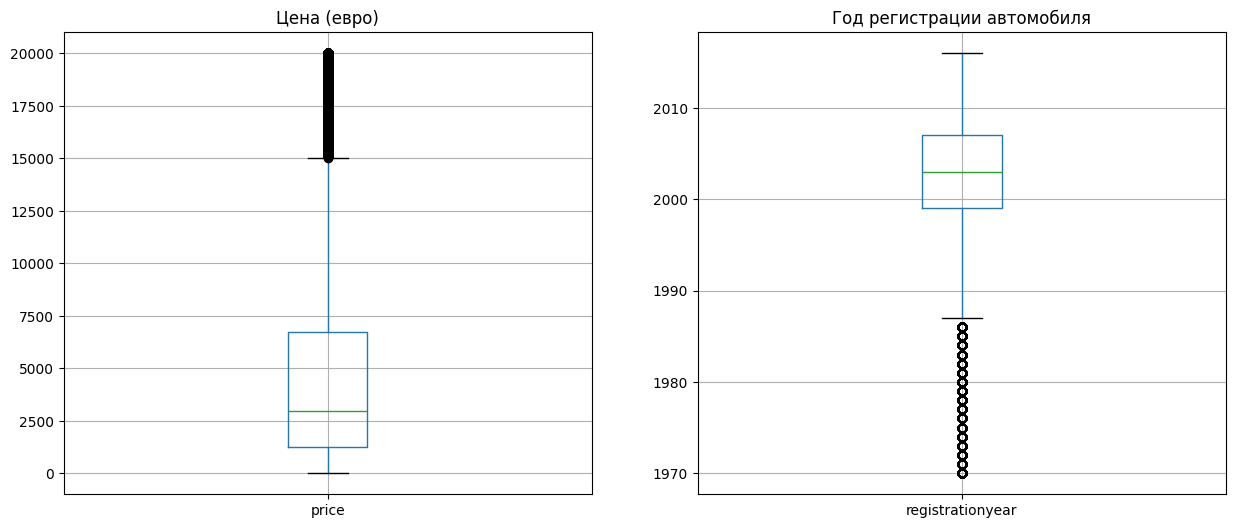

In [10]:
fig, axes = plt.subplots(1, 2, figsize=(15,6))

df1.boxplot(column = 'price', ax=axes[0])
axes[0].set_title('Цена (евро)')

df1.boxplot(column = 'registrationyear', ax=axes[1])
axes[1].set_title('Год регистрации автомобиля');

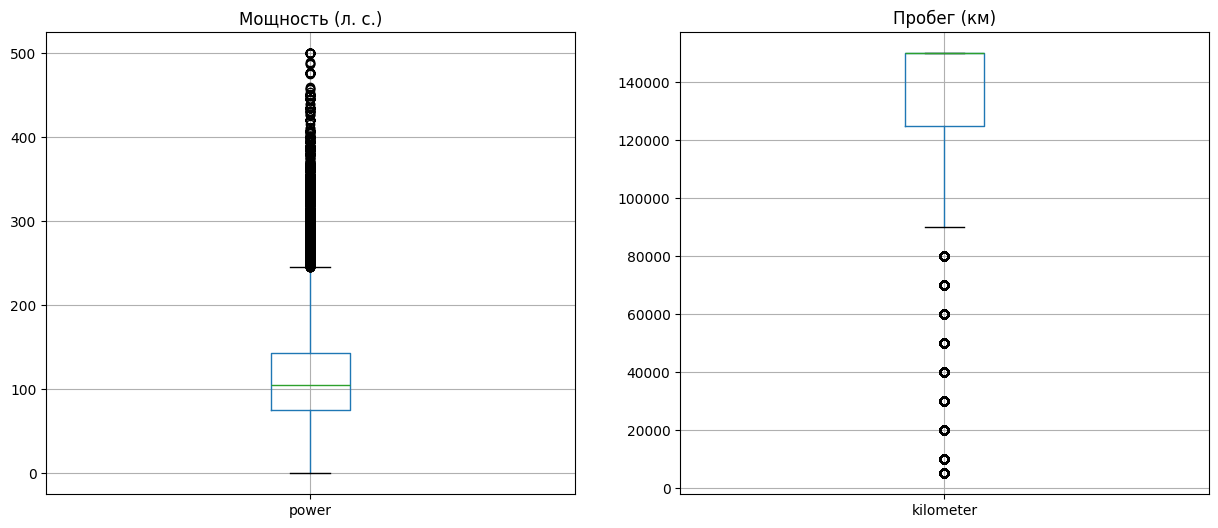

In [11]:
fig, axes = plt.subplots(1, 2, figsize=(15,6))

df1.boxplot(column = 'power', ax=axes[0])
axes[0].set_title('Мощность (л. с.)');

df1.boxplot(column = 'kilometer', ax=axes[1])
axes[1].set_title('Пробег (км)');

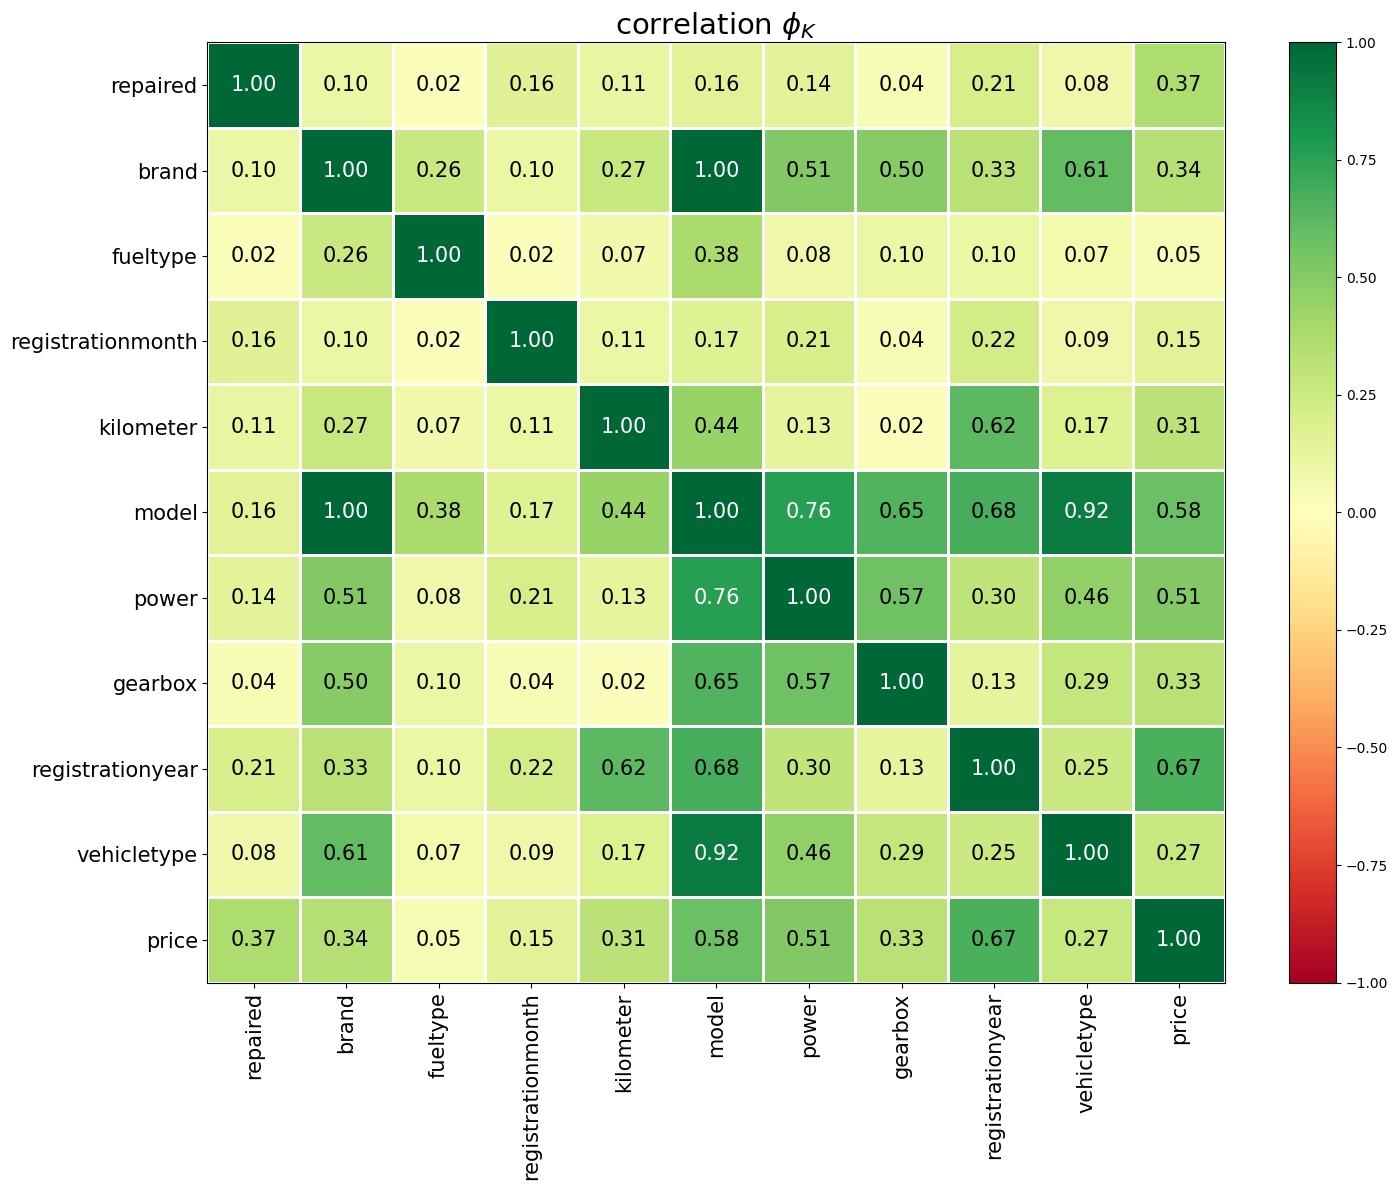

In [12]:
interval_cols = list(df1.select_dtypes(include='number').columns)

for col in ['registrationyear', 'registrationmonth']:
    interval_cols.remove(col)
    
phik_overview = df1.phik_matrix(interval_cols=interval_cols)

plot_correlation_matrix(
    phik_overview.values,
    x_labels=phik_overview.columns,
    y_labels=phik_overview.index,
    title=r"correlation $\phi_K$",
    fontsize_factor=1.5,
    figsize=(15, 12)
)

В матрице Фи-корреляций мы видим мультиколлинеарность между Model и Brand (они взаимосвязаны. Если мы знаем Model, то мы точно назовем Brand)  

Удалим столбцы Brand (так как в Model куда больше наименований)

In [13]:
df1 = df1.drop(columns = ['brand'])

**ВЫВОДЫ ПО РАЗДЕЛУ:**
1) Открыли датасет с данными по машинам. 354369 строки и 16 колонок.  
2) Преобразовали датасет - привели колонки к удобному виду, избавились от дубликатов, удалили аномалии, удалии некоторые строчки с пропущенными значениями. Заменили некоторые значения на более грамотные, так как могут привести к плохому обучению.  
3) По матрице Фи-корреляций нашли мультиколлинеарность, удалили колонку Brand.

Done! Use 'show' commands to display/save.   |█████████████████████████████████████████| [100%]   00:00 -> (00:00 left)



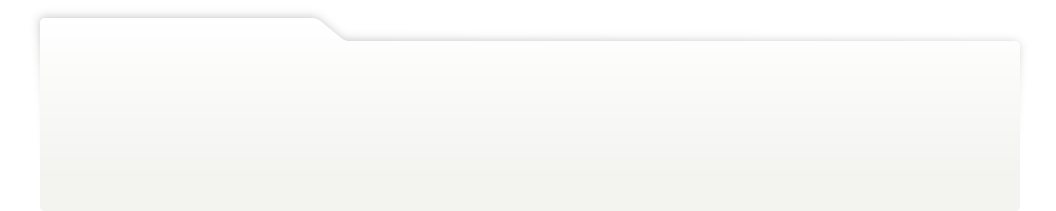
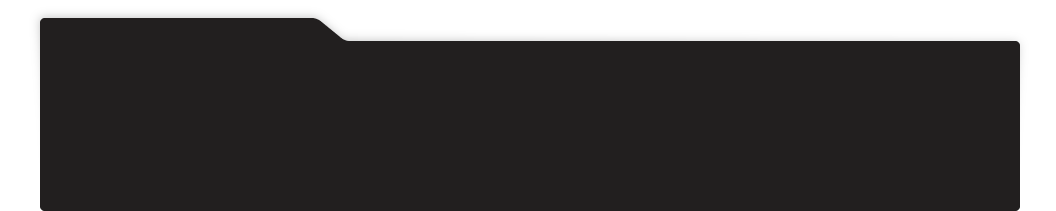
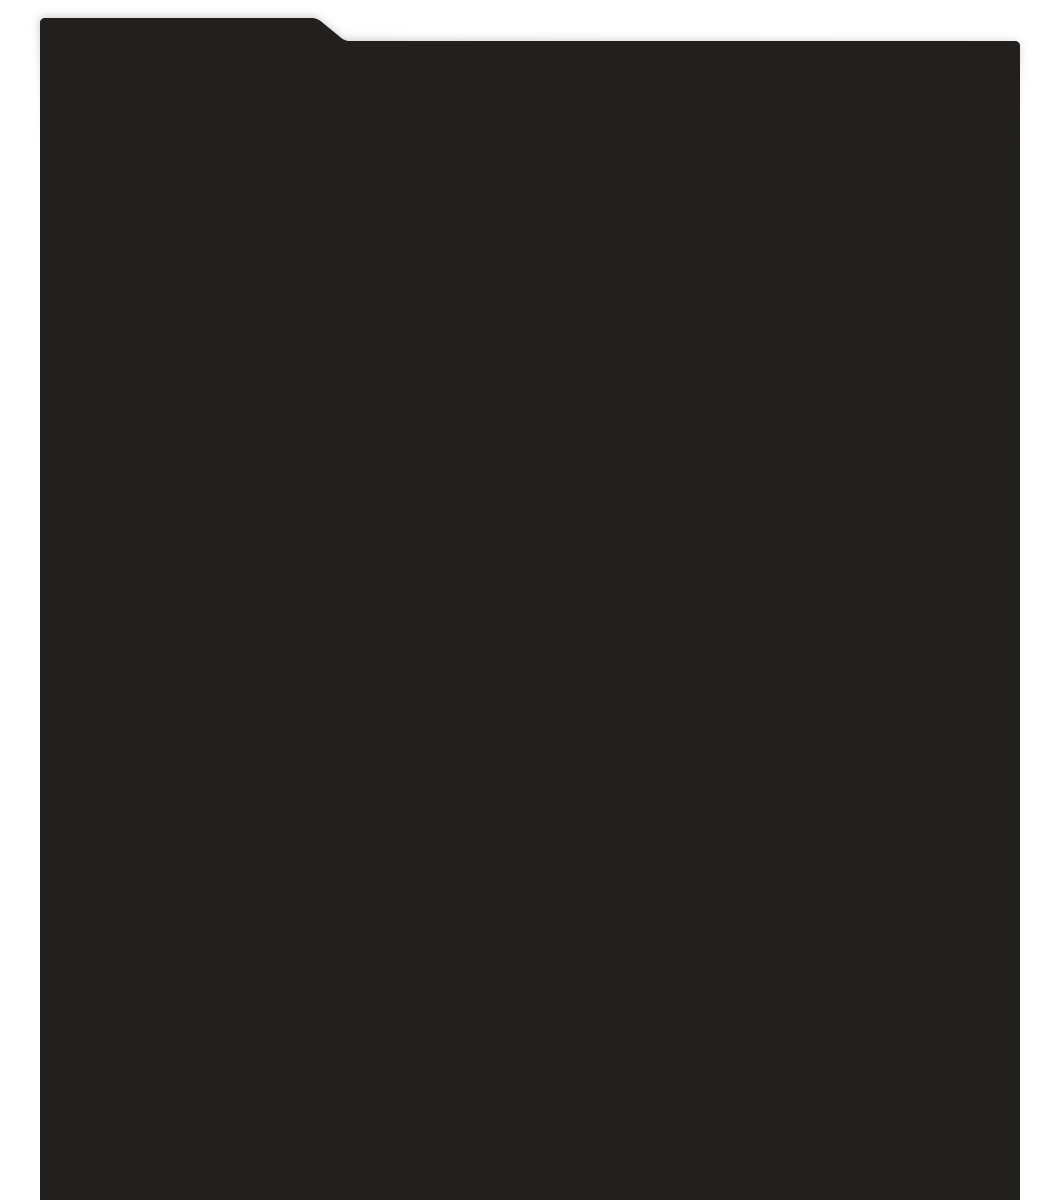
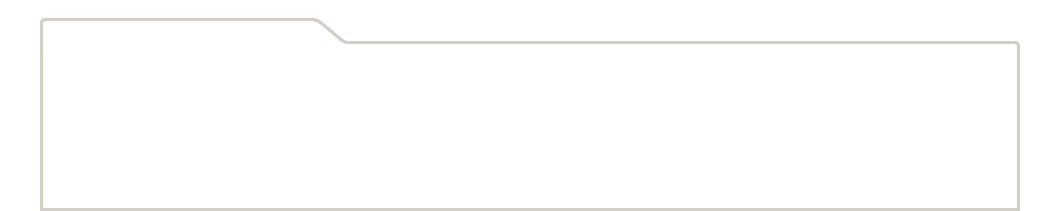
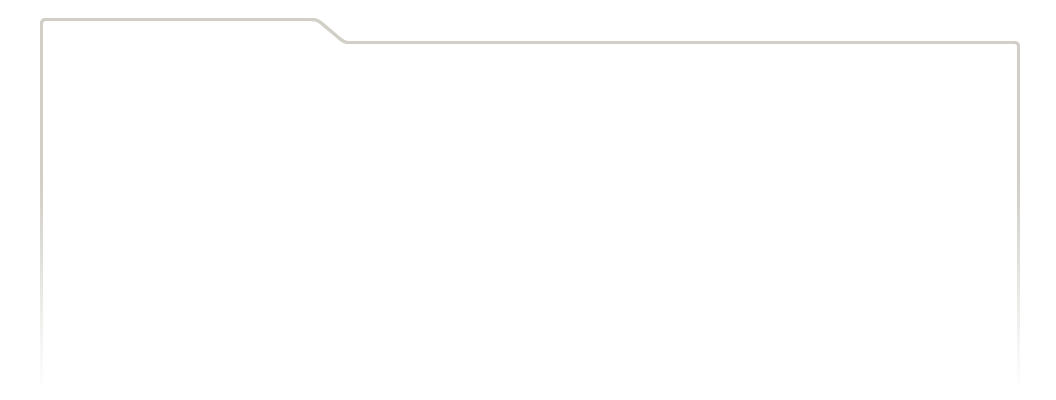
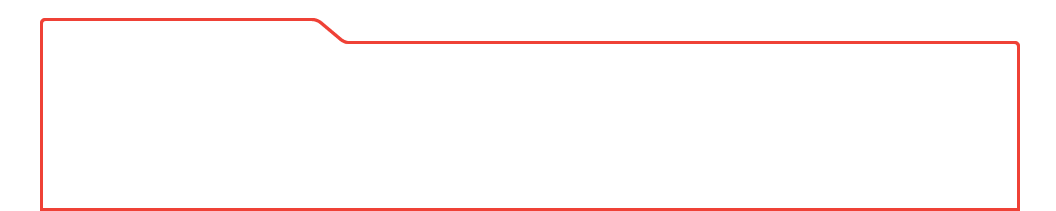
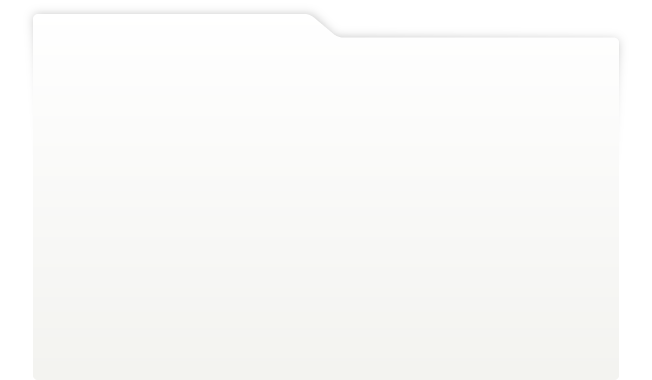
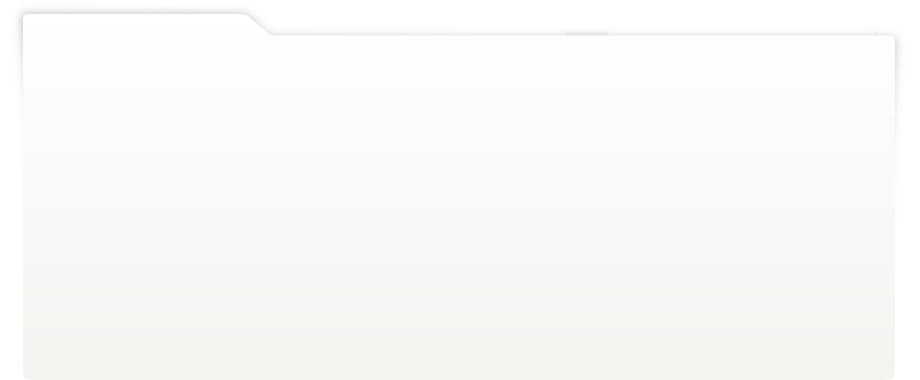
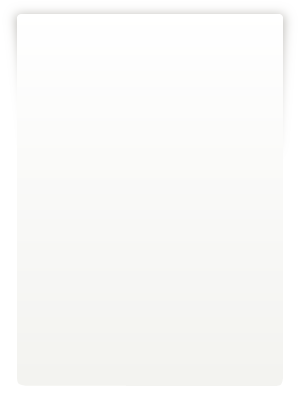
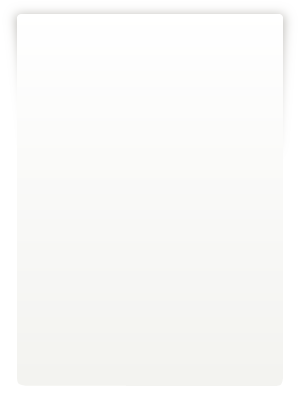
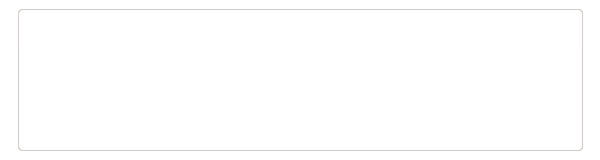
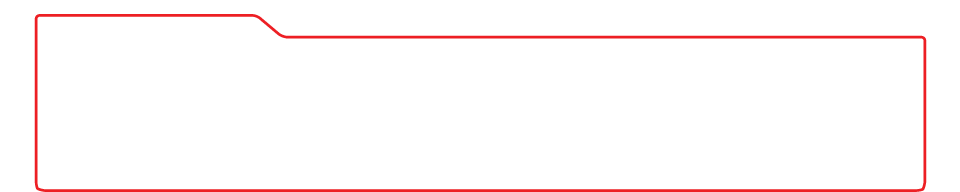
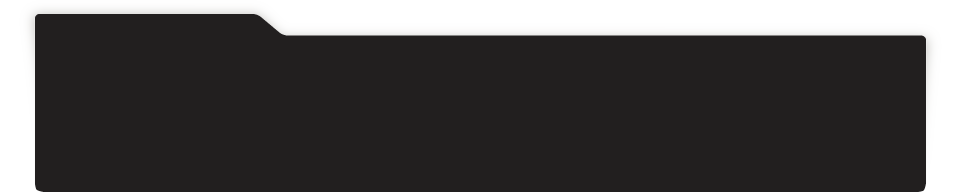
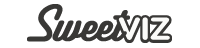
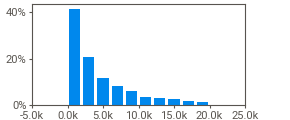
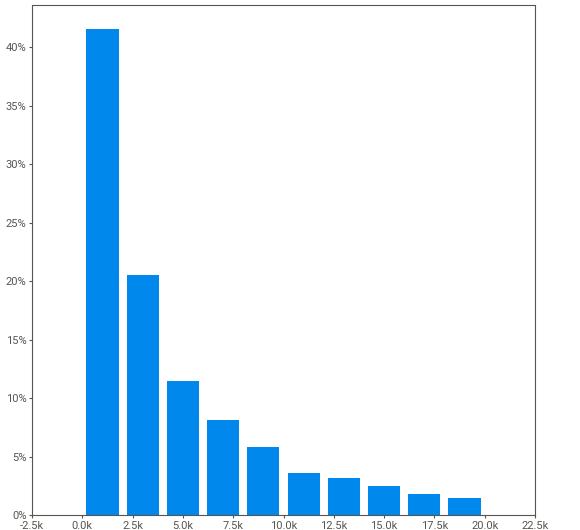
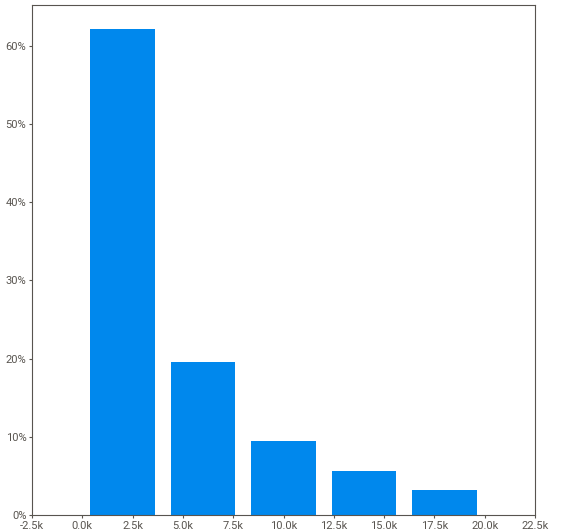
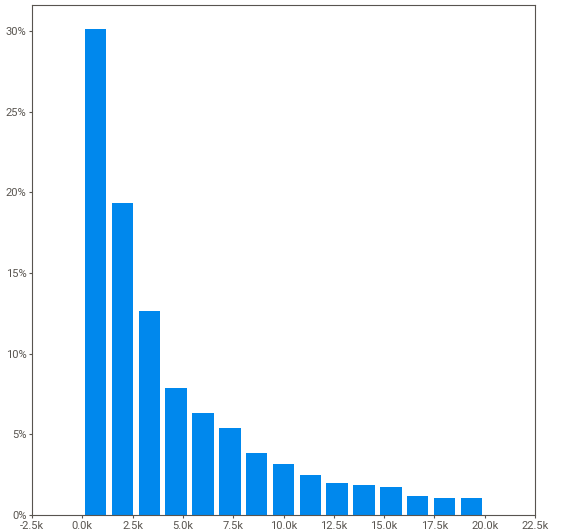
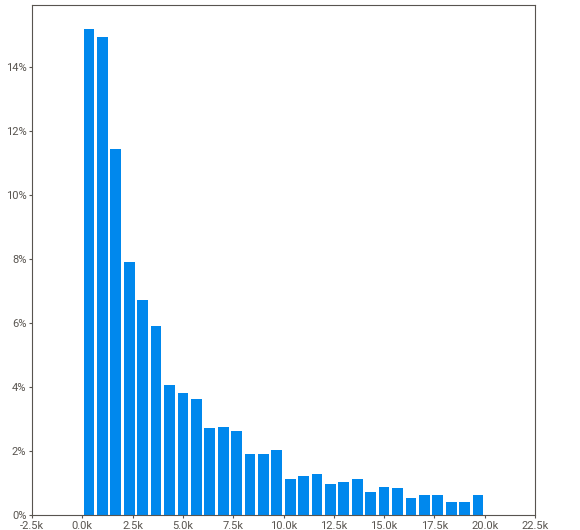
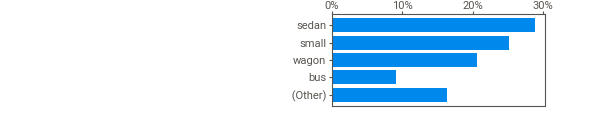
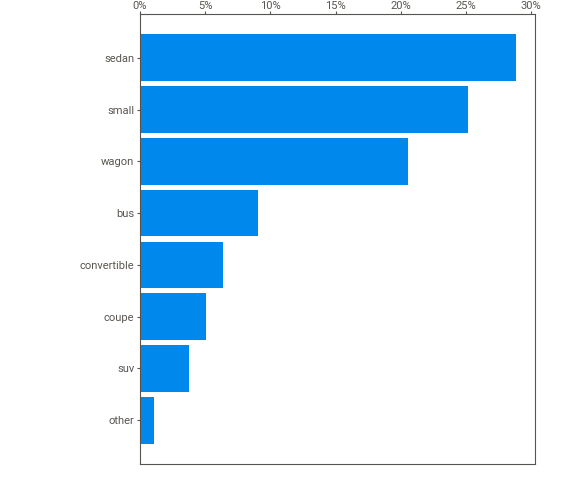
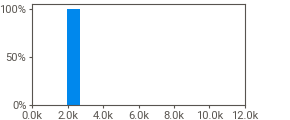
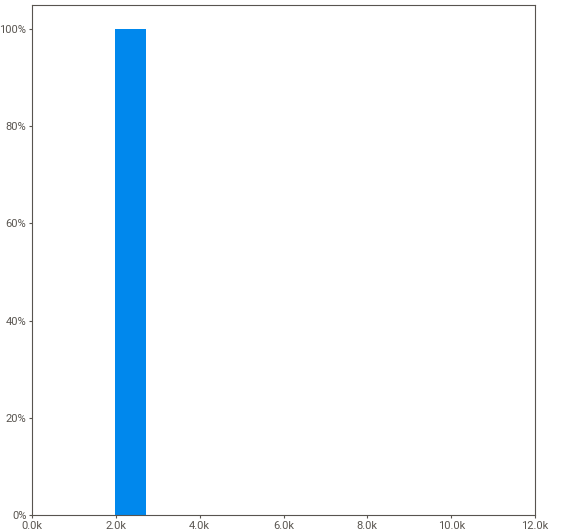
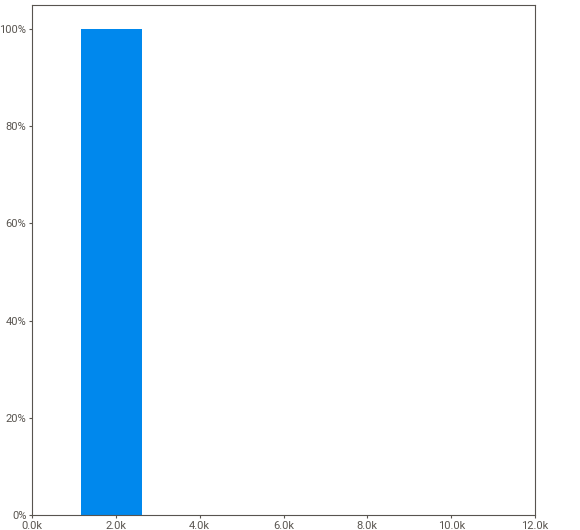
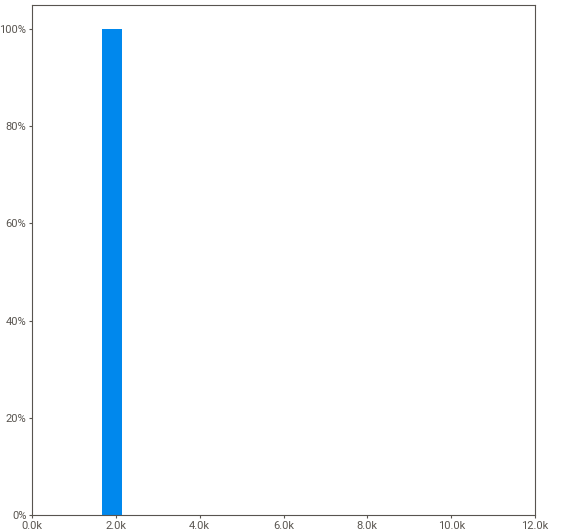
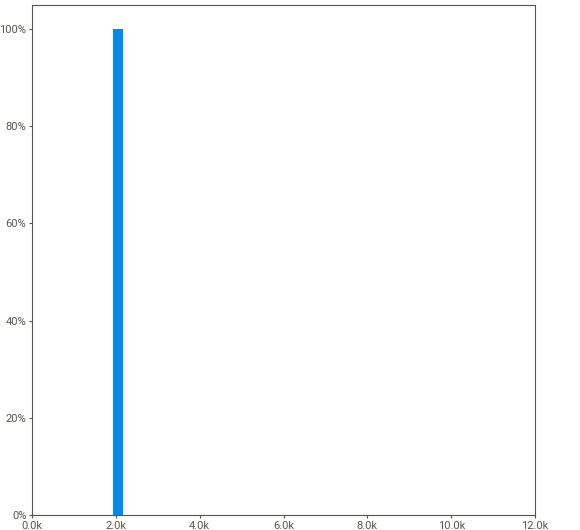
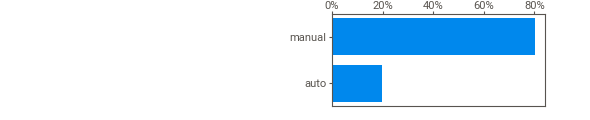
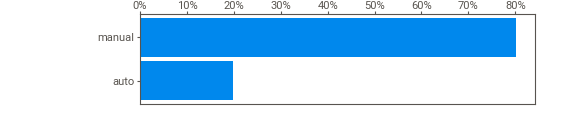
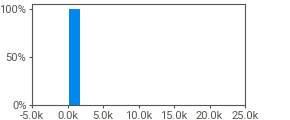
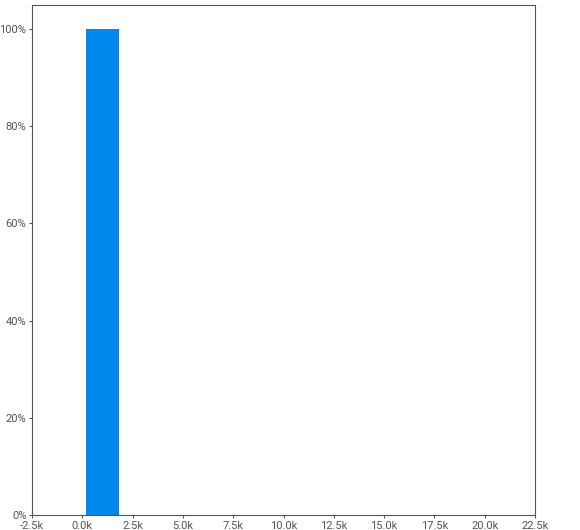
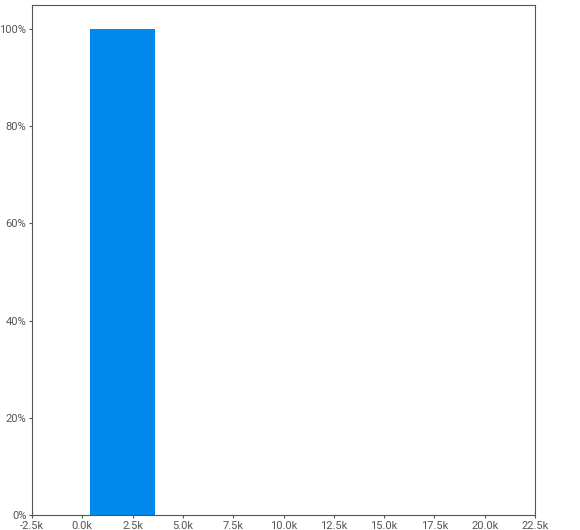
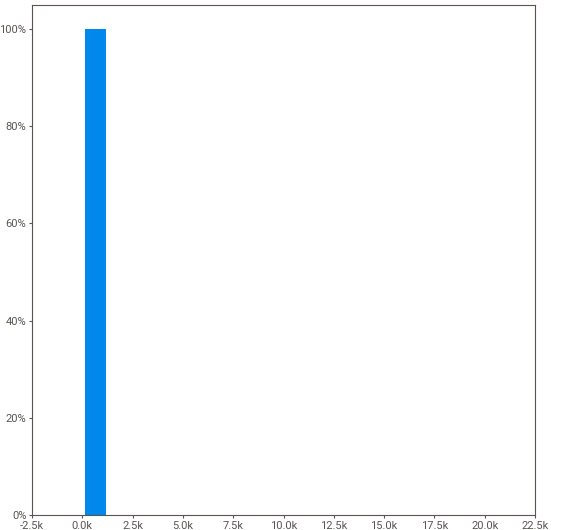
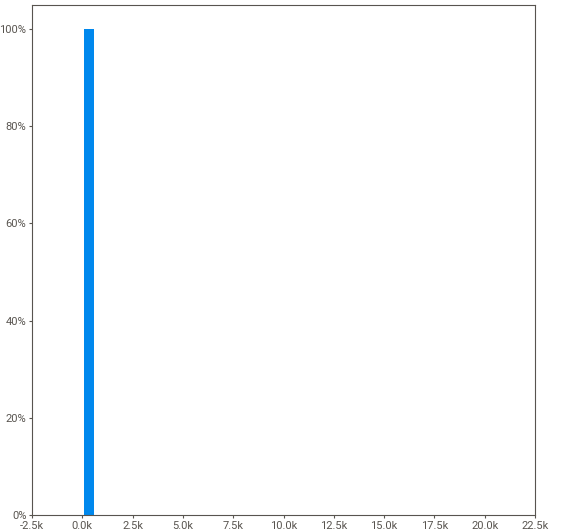
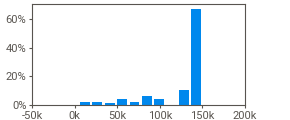
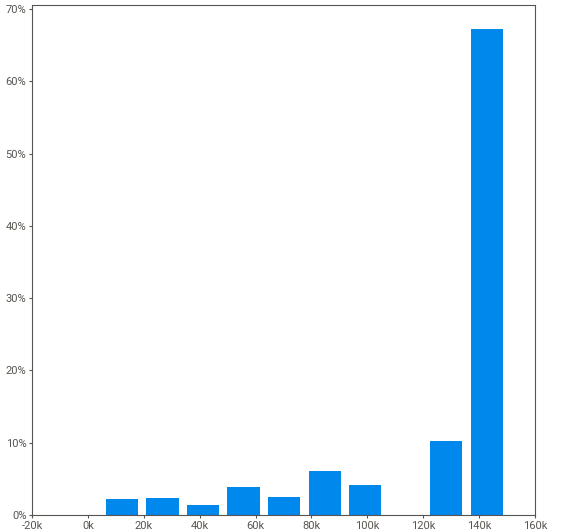
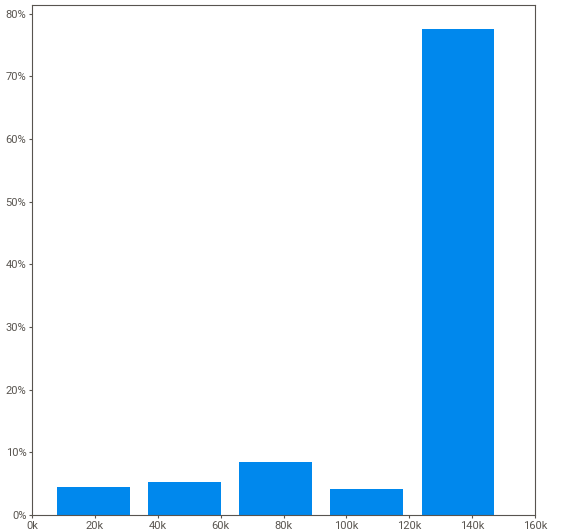
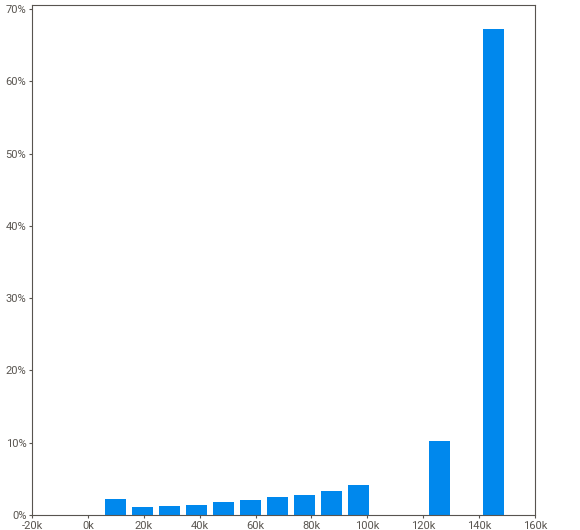
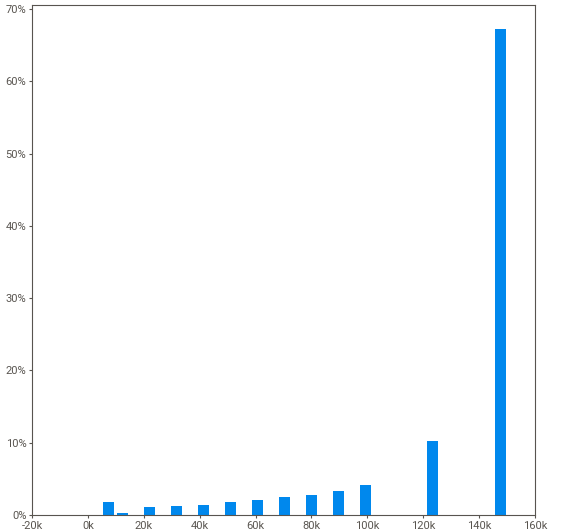
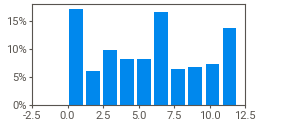
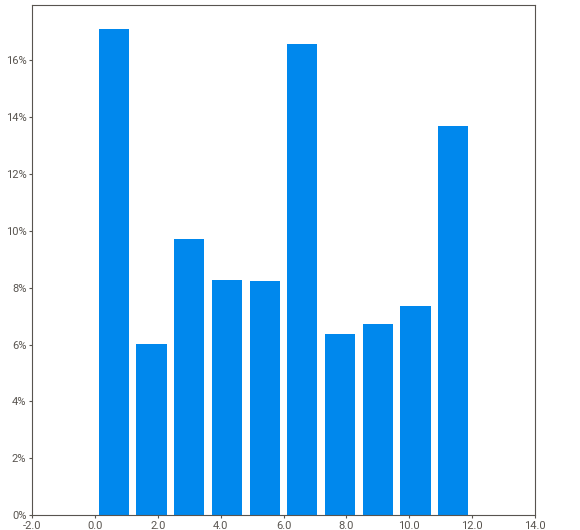
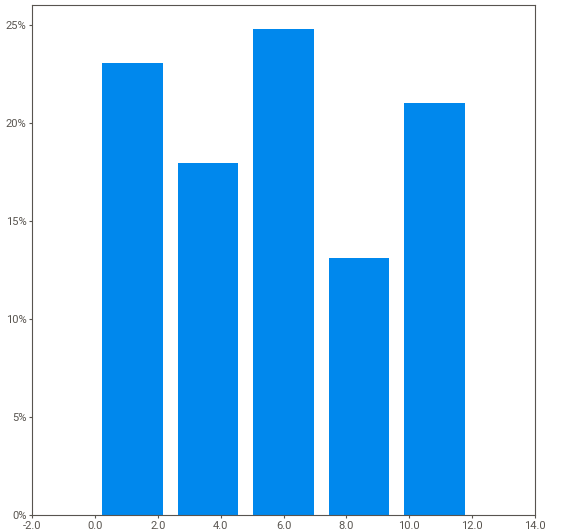
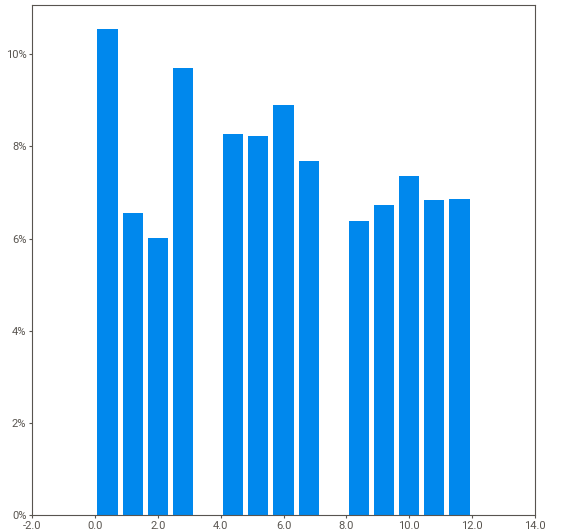
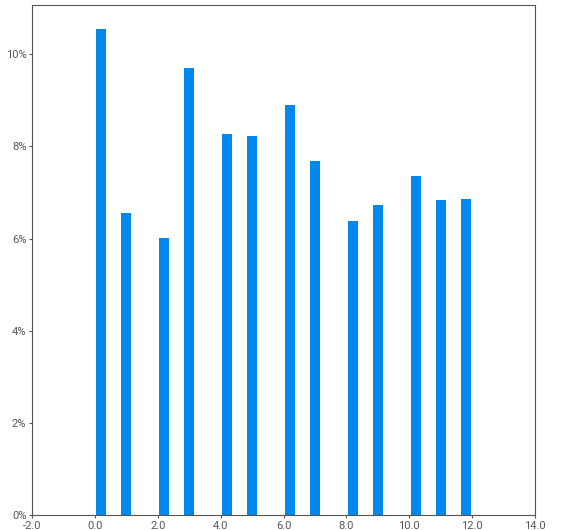
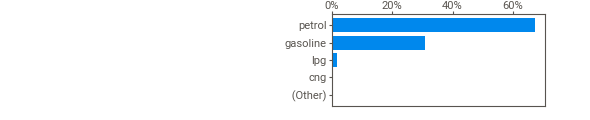
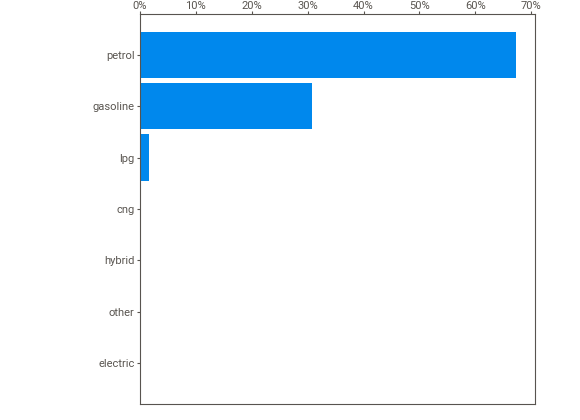
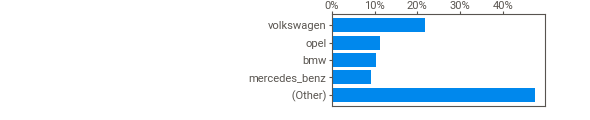
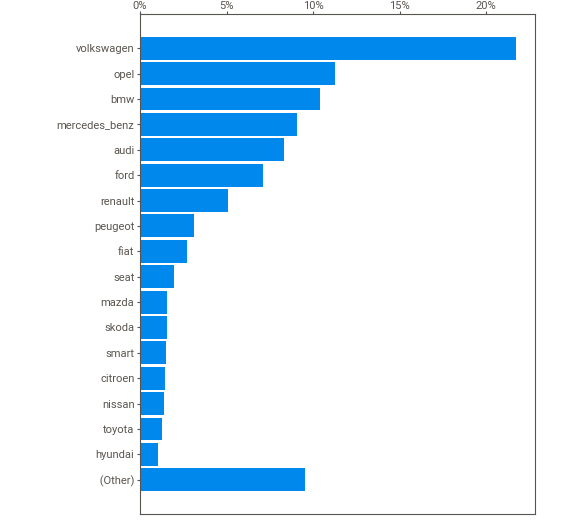
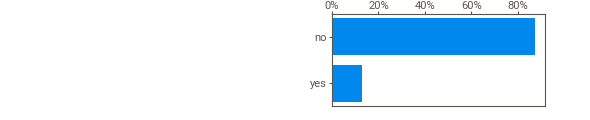
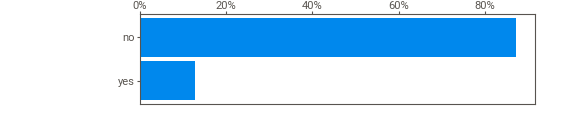
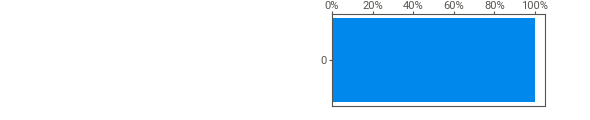
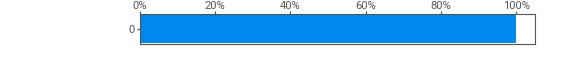
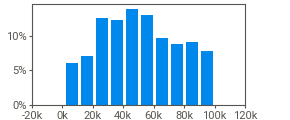
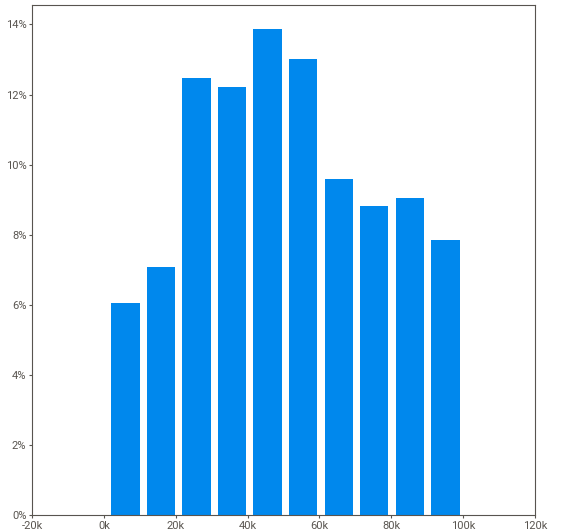
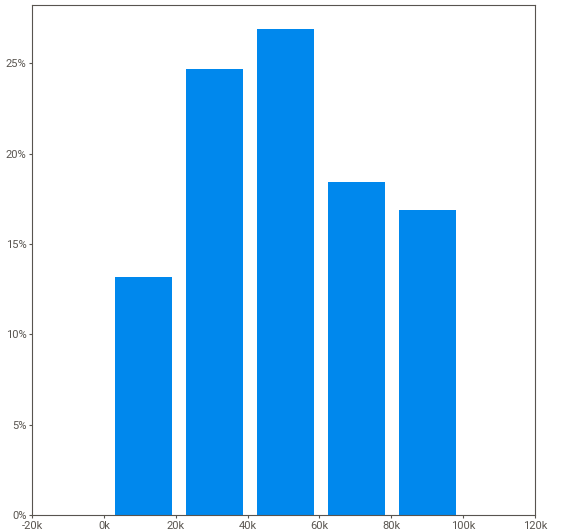
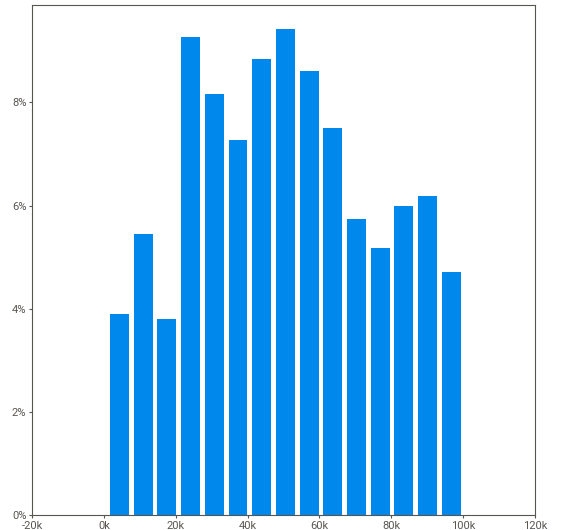
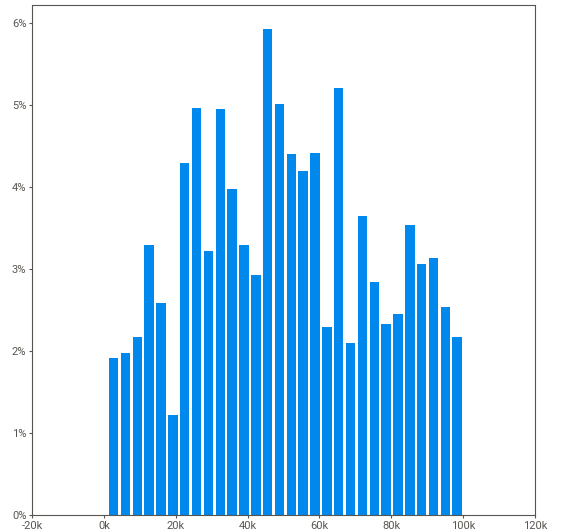
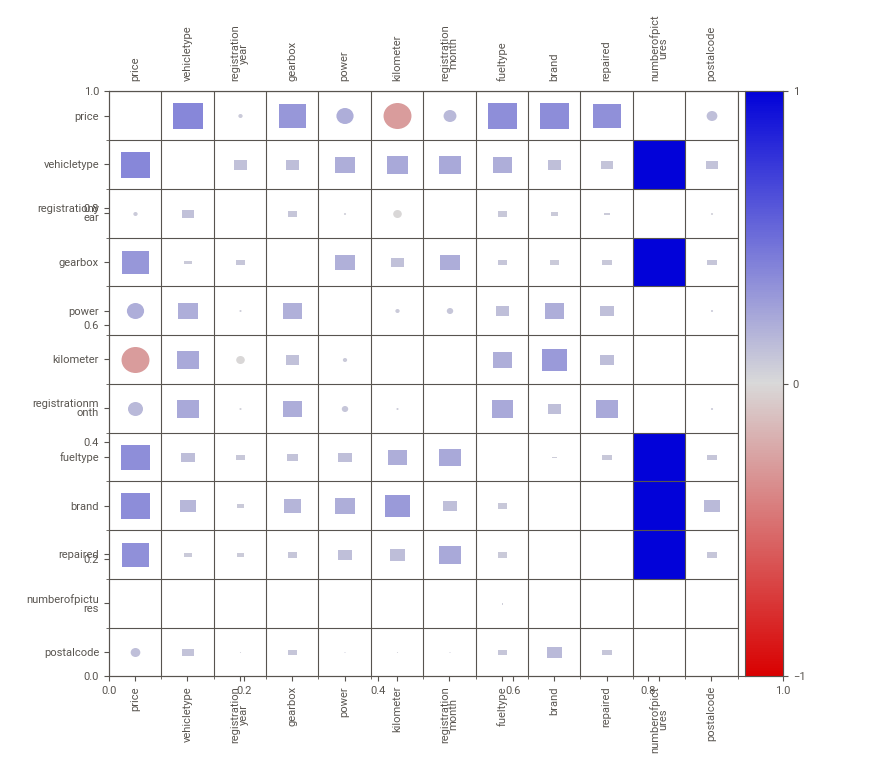
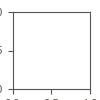

In [14]:
df_sweetviz = sv.analyze(df)
df_sweetviz.show_notebook()

<a id="обучение"></a> 
## Обучение моделей

In [15]:
df1

,price,vehicletype,registrationyear,gearbox,power,model,kilometer,registrationmonth,fueltype,repaired
0,480,NaN,1993,manual,0,golf,150000,0,petrol,NaN
1,9800,suv,2004,auto,163,grand,125000,8,petrol,NaN
2,1500,small,2001,manual,75,golf,150000,6,petrol,no
3,3600,small,2008,manual,69,fabia,90000,7,petrol,no
4,650,sedan,1995,manual,102,3er,150000,10,petrol,yes
...,...,...,...,...,...,...,...,...,...,...
313016,3200,sedan,2004,manual,225,leon,150000,5,petrol,yes
313017,1150,bus,2000,manual,0,zafira,150000,3,petrol,no
313018,1199,convertible,2000,auto,101,fortwo,125000,3,petrol,no
313019,9200,bus,1996,manual,102,transporter,150000,3,petrol,no


In [16]:
X = df1.drop('price', axis=1)
y = df1['price']


X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.20, random_state=RANDOM_STATE)

X_train, X_valid, y_train, y_valid = train_test_split(X_temp, y_temp, test_size=0.25, random_state=RANDOM_STATE)

X_train = X_train.copy()
X_test  = X_test.copy()
X_valid = X_valid.copy()

cat_cols = ['vehicletype', 'gearbox', 'model', 'fueltype', 'registrationmonth', 'repaired']
num_cols = X_train.columns.difference(cat_cols)

X_train[cat_cols] = X_train[cat_cols].astype('category')
X_test[cat_cols] = X_test[cat_cols].astype('category')
X_valid[cat_cols] = X_valid[cat_cols].astype('category')

Поделим наши данные на 3 части. 60% - тренировочные данные. По 20% - валидационные (для оценки качества) и тестовые

**1) Обучим модель LightGBM**  
Для начала найдем на тестовой выборке лучшие гиперпараметры

In [17]:
param_dist1 = {
    'num_leaves': [40, 50],
    'learning_rate': [0.01, 0.05],
    'n_estimators': [200, 300],
    'max_depth': [10, 20]
}

lgb_model = lgb.LGBMRegressor(objective='regression', random_state=RANDOM_STATE, n_jobs=-1)

rs1 = RandomizedSearchCV(
    estimator=lgb_model,
    param_distributions=param_dist1,
    n_iter=4,
    scoring='neg_root_mean_squared_error',
    cv=3,
    verbose=1,
    random_state=RANDOM_STATE
)

rs1.fit(X_train, y_train)

best_params = rs1.best_params_

print('Лучшие гиперпараметры:', best_params)
print(f"RMSE (train): {-rs1.best_score_:.2f}")

Fitting 3 folds for each of 4 candidates, totalling 12 fits
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001675 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 556
[LightGBM] [Info] Number of data points in the train set: 125208, number of used features: 9
[LightGBM] [Info] Start training from score 4653.457455
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001656 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 552
[LightGBM] [Info] Number of data points in the train set: 125208, number of used features: 9
[LightGBM] [Info] Start training from score 4674.025318
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001591 seconds.
You can set `force_r

In [18]:
results_df1 = pd.DataFrame(rs1.cv_results_)
results_df1

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_num_leaves,param_n_estimators,param_max_depth,param_learning_rate,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,0.467035,0.004073,0.088145,0.002081,40,200,10,0.01,"{'num_leaves': 40, 'n_estimators': 200, 'max_depth': 10, 'learning_rate': 0.01}",-1934.061937,-1940.409390,-1930.097638,-1934.856322,4.247065,4
1,0.541497,0.011448,0.096022,0.000817,50,200,10,0.01,"{'num_leaves': 50, 'n_estimators': 200, 'max_depth': 10, 'learning_rate': 0.01}",-1908.779832,-1915.860415,-1905.800944,-1910.147064,4.219023,2
2,0.532251,0.003284,0.097157,0.002348,50,200,20,0.01,"{'num_leaves': 50, 'n_estimators': 200, 'max_depth': 20, 'learning_rate': 0.01}",-1908.779832,-1915.876323,-1905.818132,-1910.158096,4.220309,3
3,0.561022,0.003608,0.147033,0.001633,40,300,20,0.05,"{'num_leaves': 40, 'n_estimators': 300, 'max_depth': 20, 'learning_rate': 0.05}",-1597.118811,-1607.900582,-1595.774720,-1600.264704,5.427192,1


Теперь обучим модель с уже найденными гиперпараметрами на тренировочной выборке и проверим на валидационной

In [19]:
lgb_model_best = lgb.LGBMRegressor(objective='regression',
                                     random_state=RANDOM_STATE,
                                     n_jobs=-1,
                                     **best_params)

t0 = time.perf_counter()
lgb_model_best.fit(X_train, y_train)
t_fit_train_only = time.perf_counter() - t0


t1 = time.perf_counter()
pred_valid = lgb_model_best.predict(X_valid)
predict_time_valid = time.perf_counter() - t1

valid_rmse = np.sqrt(mean_squared_error(y_valid, pred_valid))

print(f"Время обучения (train): {t_fit_train_only:.2f} сек")
print(f"Время предсказания (valid): {predict_time_valid:.2f} сек")
print(f"RMSE (valid): {valid_rmse:.2f}")

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003085 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 556
[LightGBM] [Info] Number of data points in the train set: 187812, number of used features: 9
[LightGBM] [Info] Start training from score 4665.522192
Время обучения (train): 0.70 сек
Время предсказания (valid): 0.15 сек
RMSE (valid): 1568.54


**2) Второй моделью возьмем DecisionTreeRegressor**

In [20]:
num_transformer = SimpleImputer(strategy='median')
cat_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='unknown')),
    ('encoder', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1))
])

preprocessor = ColumnTransformer(transformers=[
    ('num', num_transformer, num_cols),
    ('cat', cat_transformer, cat_cols)
])

dt_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', DecisionTreeRegressor(random_state=RANDOM_STATE))
])

param_dist2 = {
    'regressor__max_depth': [10, 15, 20],     
    'regressor__min_samples_split': [5, 10, 20],  
    'regressor__min_samples_leaf': [2, 5, 10],      
    'regressor__max_features': [None, 'sqrt', 'log2', 0.5] 
}

rs2 = RandomizedSearchCV(
    estimator=dt_model,
    param_distributions=param_dist2,
    n_iter=4,
    scoring='neg_root_mean_squared_error',
    cv=3,
    verbose=1,
    random_state=RANDOM_STATE
)

rs2.fit(X_train, y_train)

best_params_tree = rs2.best_params_

print('Лучшие гиперпараметры:', best_params_tree)
print(f"RMSE (train): {-rs2.best_score_:.2f}")

Fitting 3 folds for each of 4 candidates, totalling 12 fits
Лучшие гиперпараметры: {'regressor__min_samples_split': 20, 'regressor__min_samples_leaf': 5, 'regressor__max_features': None, 'regressor__max_depth': 20}
RMSE (train): 1912.26


In [21]:
results_df2 = pd.DataFrame(rs2.cv_results_)
results_df2

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_regressor__min_samples_split,param_regressor__min_samples_leaf,param_regressor__max_features,param_regressor__max_depth,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,0.400324,0.008423,0.065491,0.000593,20,5,None,20,"{'regressor__min_samples_split': 20, 'regressor__min_samples_leaf': 5, 'regressor__max_features': None, 'regressor__max_depth': 20}",-1903.137369,-1920.109213,-1913.525557,-1912.257380,6.986515,1
1,0.205505,0.001078,0.060721,0.000274,10,2,sqrt,10,"{'regressor__min_samples_split': 10, 'regressor__min_samples_leaf': 2, 'regressor__max_features': 'sqrt', 'regressor__max_depth': 10}",-2274.181837,-2257.674194,-2232.644674,-2254.833569,17.076023,4
2,0.316344,0.008138,0.065057,0.003632,10,5,None,10,"{'regressor__min_samples_split': 10, 'regressor__min_samples_leaf': 5, 'regressor__max_features': None, 'regressor__max_depth': 10}",-2031.710658,-2030.120163,-2016.054791,-2025.961871,7.035391,2
3,0.252393,0.005457,0.068365,0.005300,20,2,sqrt,20,"{'regressor__min_samples_split': 20, 'regressor__min_samples_leaf': 2, 'regressor__max_features': 'sqrt', 'regressor__max_depth': 20}",-2043.983834,-2017.211324,-2031.358257,-2030.851138,10.935712,3


In [22]:
final_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', DecisionTreeRegressor(random_state=RANDOM_STATE))
])

final_model.set_params(**best_params_tree)

t0 = time.perf_counter()
final_model.fit(X_train, y_train)
tree_fit_train_only = time.perf_counter() - t0

t1 = time.perf_counter()
pred_valid_tree = final_model.predict(X_valid)
predict_time_valid = time.perf_counter() - t1

valid_rmse_tree = np.sqrt(mean_squared_error(y_valid, pred_valid_tree))

print(f"Время обучения (train): {tree_fit_train_only:.2f} сек")
print(f"Время предсказания (valid): {predict_time_valid:.2f} сек")
print(f"RMSE (valid): {valid_rmse_tree:.2f}")

Время обучения (train): 0.60 сек
Время предсказания (valid): 0.07 сек
RMSE (valid): 1836.85


**Вывод:**  
Время обучения, Время предсказания лучше у DecisionTreeRegressor.  
А вот RMSE лучше у LightGBM. Он у нас основной параметр, так что будем работать дальше с этой моделью

<a id="анализ"></a> 
## Анализ моделей

Теперь проверим качество модели LightGBM на тестовых данных:

In [23]:
X_train_valid = pd.concat([X_train, X_valid], axis=0)
y_train_valid = pd.concat([y_train, y_valid], axis=0)
X_train_valid[cat_cols] = X_train_valid[cat_cols].astype('category')

t0 = time.perf_counter()
lgb_model_best.fit(X_train_valid, y_train_valid)
fit_time_final = time.perf_counter() - t0

t2 = time.perf_counter()
preds_test = lgb_model_best.predict(X_test)
predict_time_test = time.perf_counter() - t2

test_rmse = np.sqrt(mean_squared_error(y_test, preds_test))

print(f"Время обучения (train+valid): {fit_time_final:.2f} сек")
print(f"Время предсказания (test): {predict_time_test:.2f} сек")
print(f"RMSE (test): {test_rmse:.2f}")

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004133 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 556
[LightGBM] [Info] Number of data points in the train set: 250416, number of used features: 9
[LightGBM] [Info] Start training from score 4661.005623
Время обучения (train+valid): 0.87 сек
Время предсказания (test): 0.16 сек
RMSE (test): 1596.63


Посмотрим на важность признаков

In [24]:
importances = lgb_model_best.feature_importances_
features = X_train_valid.columns

fi = pd.Series(importances, index=features).sort_values(ascending=False)
fi

model                3257
registrationyear     2719
power                2485
kilometer            1146
registrationmonth     682
vehicletype           628
repaired              375
gearbox               313
fueltype               95
dtype: int32

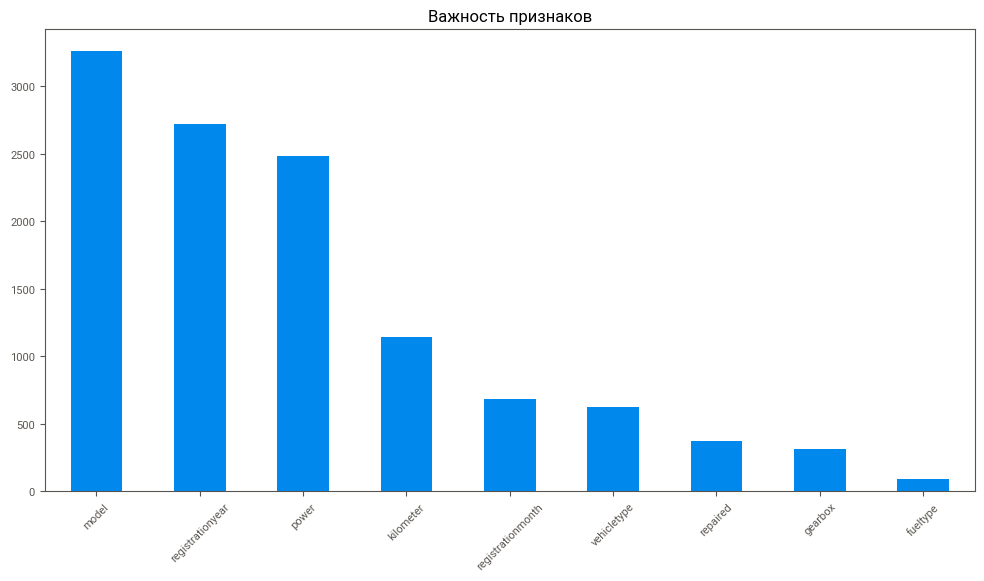

In [25]:
plt.figure(figsize=(12,6))
fi.plot(kind='bar')
plt.xticks(rotation=45)
plt.title('Важность признаков');

**Вывод по разделу:**
- Обучили модель LightGBM, разделив данные на train и test. Время обучения: 0.77 сек, Время предсказания: 0.15 сек. Test RMSE: 1596.63
- По важности признаком можно отметить, что модель, год регистрации и мощность влияют сильнее остальных

<a id="вывод"></a> 
## Вывод

- Был проанализирован датасет с данными по автомобилям. 354369 строки и 16 колонок. Привели колонки к удобному виду, избавились от дубликатов, удалили аномалии, удалии некоторые строчки с пропущенными значениями. Заменили некоторые значения на более грамотные, так как могут привести к плохому обучению.
По матрице Фи-корреляций нашли мультиколлинеарность, удалили колонку Brand.
- Обучили две модели - LightGBM и DecisionTreeRegressor. Оценили их на валидационной выборке метрикой RMSE. Проанализировали время обучения и время предсказания на valid. Время обучения и время предсказания лучше у DecisionTreeRegressor. RMSE лучше у LightGBM (1568 против 1836 у DecisionTreeRegressor). Поэтому выбор остался за ней
- Заново обучили модель LightGBM, разделив данные только на train и test. RMSE 1596.63. По важности признаком модель, год регистрации и мощность влияют сильнее остальных